### 1. Introduction
BioCRNpyler is a software tool designed to rapidly compile large biological chemical reaction networks (CRNs) from simple user specifications (written in python). It has built in support of a number of models for transcription, translation, and gene expression regulation using components common in _E. coli_ synthetic biology. This tutorial explains the inner workings of BioCRNpyler and shows how to create custom mixtures, components, and mechanisms. Specifically, we will go through making a custom gene expression model:
<br>
>$G \to G + P \rightleftharpoons G:P \to G + P + X$

here $G$ is a gene and $P$ is a polymerase and $X$ is the protein expressed by $G$. No translational machinery is included in this model, making it one of the simplest possible for expression. Note that we are ignoring translation for simplicitiy, not becuase it isn't important.

On the top level, BioCRNpyler uses three kinds of objects:
* __Mechanisms__: are the details of how a physics process is implemented as a CRN. These take the form of black box reaction schemas which compile into a CRN containing all the intermediate steps required to get from a specified input to an output.
* __Components__: are the ingredients one might imagine adding to a test tube, say from a pipette. They do not include all chemical species involved in a reaction, but just the key ones we might experimentally modulate. Components may contain their own mechanisms or default to those used by a mixture. An example of a component is a piece of DNA encoding a gene. A DNA-Transcription factor complex, on the other hand, would not normally be a component.
* __Mixtures__: can be thought of as the "reaction soup" we are working in. Mixtures contain default components and mechanisms. Components are added to mixtures to create different reaction conditions. 

Internally, BioCRNpyler tells the Mixture to compile all its Components. Each Component contains its own Mechanisms (or defaults to Mechanisms defined in the Mixture) and calls each Mechanism (read: reaction schema) to generate a set of chemical species and reactions which are combined into a complete CRN. BioCRNpyler also has its own internal CRN representation, which we will discuss next.

### Chemical Reaction Network (CRN) model
A CRN is a set of species $S$ and a set of reactions $R$ where each reaction is expressed $I \rightarrow O$ where $I$ are the inputs species, $O$ are the output species. Each reaction occurs with a rate function (propensity) $\rho(x)$ which takes the state of the CRN (the values of all the species) as an input. By default, reactions use massaction rates: $\rho(x) = k  \Pi_{s \in I} x_s$ here $k$ is some constant and $x_s$ is the value of the species $s$. A number of built in propensities exist and are described in the documentation, including a general propensity allowing for an arbitrary function. 

Internally, BioCRNpyler represents species as strings involving a type identifier and a name: type_name. This is to allow for species to be identified as "gene_X", "mrna_X", etc. Complexes between species can be created automatically using the complex_specie function or given custom defined names. By default, a complex of gene_X and protein_Y would be called complex_gene_X_protein_Y. This would be considered different from complex_protein_Y_gene_X in Bioscrape's CRN semantics because species here are effectively strings.

Reactions are stored as lists of species (for the inputs and outputs) and a rate constant k. Non massaction reactions also require a parameter dictionary of their relevant parameter values. Massaction reactions are allowed to be reversible, in which case they are thought of as two irreversible reactions. Reaction rates default to 1.0.

Now, we will create the CRN described above directly and approximate it with a non-massaction propensity.

Species = protein_RNAP, protein_Ribo, protein_RNAase, complex_rna_G1_protein_RNAase, complex_dna_G1_protein_RNAP, rna_G1, protein_GFP, complex_rna_G1_protein_Ribo, dna_G1
Reactions = [
	dna_G1 + protein_RNAP <--> complex_dna_G1_protein_RNAP        massaction: k_f=100.0	k_r=10.0
	complex_dna_G1_protein_RNAP --> dna_G1 + rna_G1 + protein_RNAP        massaction: k_f=3.0
	rna_G1 + protein_Ribo <--> complex_rna_G1_protein_Ribo        massaction: k_f=100.0	k_r=10.0
	complex_rna_G1_protein_Ribo --> rna_G1 + protein_GFP + protein_Ribo        massaction: k_f=2.0
	rna_G1 + protein_RNAase <--> complex_rna_G1_protein_RNAase        massaction: k_f=100.0	k_r=10.0
	complex_rna_G1_protein_RNAase --> protein_RNAase        massaction: k_f=1.0
]


c:\users\apand\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\apand\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\apand\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\biocrnpyler-0.1-py3.6.egg\biocrnpyler\chemical_reaction_network.py:512: UserWarning: Warning! parameter k_local_r0_1_0 does not show up in any currently defined reactions or rules.
  m = bioscrape.types.read_model_from_sbml(filename)
c:\users\apand\appdata\local\programs\py

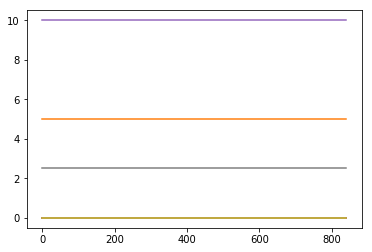

In [1]:
%matplotlib inline

from biocrnpyler import *
import numpy as np

txtl = CRNLab("GFP")

txtl.mixture("mixture1", extract = "test_extract", extract_volume = 1e-6)

# Or simply add a new dna in one line as follows.
txtl.add_dna(name = "G1", promoter = "pBest", rbs = "BCD2", protein = "GFP", initial_conc = 10, volume = 1e-7)

# Combine all of the tubes together to get the model
well1 = txtl.get_model()
print(well1)
# Create an SBML file containing the model
filename = "geneexpr.xml"
txtl.write_sbml_file(filename)

# Run a simulation (using bioscrape) and plot the result
# (Optional) Specify the type of simulation (deterministic or stochastic)
timepoints = np.linspace(0,14*60,100)
simdata = well1.runsim_bioscrape(timepoints, filename, simtype = "stochastic", plot_show = True)

### 2. Creating a Custom Mechanism: GeneExpression
To create custom Mechanism objects, subclass the Mechanism class and rewrite the object constructor, the update_species function, and the update_reactions function. Briefly:
* In the constructor we will set the name of the mechanism and the name of the polymerase species, rnap. 
* In update_species, we will create a list of all the species used in the reaction schema: the gene, gene-rnap complex, and the product species.
* In update_reactions we create a list of all the reactions required for our reaction schema: the polymerase binding and unbinding reactions as well as the reaction producing the gene product X. 

Note that this code could be generated much faster using the built in MichalisMentenRXN Mechanism, but we will do it by hand here for educational purposes.

In [ ]:
from biocrnpyler.mechanism import Mechanism



class GeneExpression(Mechanism):
    #Overwrite the constructor. 
    #    Name: the name of the Mechanism (set when it is instantiated).
    #    rnap: the polymerase, which we will allow to be multiple types of object for user convenience
    #    type: this is the "kind" of mechanism - used as a key in mechanism dictionaries
    def __init__(self, name, rnap, type = "gene_expression", **keywords):
        #Check if the rnap type specie (see chemical reaction network details below)
        if isinstance(rnap, Specie):
            self.rnap = rnap
        #or is type string, in which case create a 
        elif isinstance(rnap, str):
            self.rnap = Specie(name = rnap, type = "protein")
        #someone might make RNAP a component if they want to add it to a mixture, as you might with a T7 polymerase in a cell-free system
        elif isinstance(rnap, Component) and rnap.get_specie() != None:
            self.rnap = rnap.get_specie()
        else:
            raise ValueError("'rnap' parameter must be a string, a Component with defined get_specie(), or a chemical_reaction_network.specie")
        #The superclass constructor will take care of the name
        Mechanism.__init__(self = self, name = name, mechanism_type = type, **keywords) #MUST CALL THE SUPER CONSTRUCTOR!
    
    #Overwrite update_species:
    #    dna: the name of the gene to be expressed
    #    product: the name of the gene product
    #update_species returns a list of all species used by the reaction schema
    def update_species(self, dna, product):
        #We do not need to do a check on the DNA or product types because that will be performed at the Component level.
        #Create the list of species to return
        species = [dna, self.rnap, product]
        #The complex_specie function returns a chemical_reaction_network.specie complex made up a list of species
        species += [complex_specie([dna, self.rnap])]
        #Return a list of species
        return species
    
    #Overwrite update_species:
    #    dna: the name of the gene to be expressed
    #    product: the name of the gene product
    #    kb, ku: binding and unbinding constant for dna + rnap <--> dna:rnap
    #    kcat: rate constant for dna:rnap --> dna + rnap + product
    #update_species returns a list of all species used by the reaction schema
    #update_reactions will require rates as well as the relevant species. Returns a list of chemical_reaction_network.reaction
    def update_reactions(self, dna, product, kb, ku, kcat):
        #complex specie
        comp = complex_specie([dna, self.rnap])
        #Binding Reaction: dna + rnap <--> dna:rnap
        binding_rxn = Reaction(inputs=[dna, self.rnap], outputs=[comp], k=kb, k_rev=ku)
        #Catalytic Reaction: dna:rnap --> dna + rnap + product
        cat_rxn = Reaction(inputs=[comp], outputs=[dna, product, self.rnap], k=kcat)
        #Return a list of reactions
        return [binding_rxn, cat_rxn]

### 3. Creating a Custom Component: Gene
To create custom Component objects, subclass the Component class and rewrite constructor, update_species, and update_reactions functions.
* The Constructor: will set the name of the DNA specie and the name of the protein product
* update_species: will call each mechanism (in this case just GeneExpression) to get their species
* update_reactions: will call each mechanism (in this case just GeneExpression) to get their reactions

In general, each component's functions update_species and update_reactions need to know (via you, the programmer) what the names of the mechanisms they are expected to use are. These mechanisms will be automatically inherited from the Mixture object the Component is added to (by default) but can also be overwritten with the mechanisms keyword in the Component constructor.

In [ ]:
from biocrnpyler.component import Component

class Gene(Component):
    #OVERWRITE CONSTRUCTOR
    def __init__(self, dna_name, product, **keywords):
        #check types for name and product and set internal variables
        if isinstance(dna_name, Specie):
            self.dna = dna_name
        #or is type string, in which case create a 
        elif isinstance(dna_name, str):
            self.dna = Specie(name = dna_name, type = "dna")
        else:
            raise ValueError("dna_name must be a string or a chemical_reaction_network.specie")
        if isinstance(product, Specie):
            self.product = dna_name
        #or is type string, in which case create a 
        elif isinstance(product, str):
            self.product = Specie(name = product, type = "protein")
        else:
            raise ValueError("product must be a string or a chemical_reaction_network.specie")
        
        Component.__init__(self = self, name = dna_name, **keywords) #MUST CALL THE SUPERCLASS CONSTRUCTOR!
    
    
    #OVERWRITE update_species
    def update_species(self):
        #The Component will automatically search for a mechanism called "gene_expression", which it can find in 2 ways
        #    1: it can inherit this from its Mixture (which requires the Mixture has an appropriate "gene_expression" mechanism)
        #    2: this can be passed into the Gene constructor in a dictionary as a keyword arg mechanisms= {'gene_expression':Mechanism [Object Instance]}
        mech_express = self.mechanisms["gene_expression"] #key is the mechanism type
        
        #Return the species from the mechanisms in your mixture. In this case, just one.
        return mech_express.update_species(self.dna, self.product)
    
    #OVERWRITE update_reactions
    def update_reactions(self):
        
        #get mechanism: key is the mechanism type
        mech_express = self.mechanisms["gene_expression"] 
        
        #Component.get_parameter will automatically search a parameter dictionary for the best parameter to use.
        #The string names here, 'kexpress', 'kb', 'ku', must be defined by you to match the parameter data file.
        #see parameter loading examples for more information.
        kexpress = self.get_parameter("kexpress", part_id = self.name, mechanism = mech_express)
        kb = self.get_parameter("kb", part_id = self.name, mechanism = mech_express)
        ku = self.get_parameter("ku", part_id = self.name, mechanism = mech_express)
        
        #Return the reactions from each mechanism in your mixture. In this case, just this one.
        return mech_express.update_reactions(self.dna, self.product, ku = ku, kb = kb, kcat = kexpress)

### 4. Creating a Custom Mixture: ExpressionMixture
To create custom Mixture objects, subclass the Mixture class and rewrite the object constructor function to contain the appropriate default mechanisms and components. All other functionalities will be inherited from the Mixture super class.

In [ ]:
#ExpressionMixture
from biocrnpyler import Mixture

class ExpressionMixture(Mixture):
    #OVERWRITE THIS METHOD
    def __init__(self, name="", rnap = "RNAP", **keywords):
        #Check if the rnap type specie (see chemical reaction network details below)
        if isinstance(rnap, Specie):
            self.rnap = rnap
        #or is type string, in which case create a 
        elif isinstance(rnap, str):
            self.rnap = Specie(name = rnap, type = "protein")
        #someone might make RNAP a component if they want to add it to a mixture, as you might with a T7 polymerase in a cell-free system
        elif isinstance(rnap, Component) and rnap.get_specie() != None:
            self.rnap = rnap.get_specie()
        else:
            raise ValueError("'rnap' parameter must be a string, a Component with defined get_specie(), or a chemical_reaction_network.specie")
        
        #Create an instance of the GeneExpression mechanism
        mech_express = GeneExpression("default_gene_expression", self.rnap)
        
        #Create default mechanism dict
        default_mechanisms = {
            mech_express.type:mech_express
        }
        
        #Create default components
        default_components = [self.rnap]
        
        #MUST CALL THE SUPERCLASS CONSTRUCTOR!
        Mixture.__init__(self, name = name, default_mechanisms=default_mechanisms, default_components=default_components, **keywords)        
    

### 5. Combine everything and compile a CRN and print it.

In [ ]:
#Create a fake parameter dictionary for the example
parameters = {("default_gene_expression","Reporter", "kexpress"):1.0, 
              ("default_gene_expression","Reporter", "ku"):.01,
              ("default_gene_expression","Reporter", "kb"):100.0 }

#Instantiate a gene
G1 = Gene("Reporter", "GFP", parameters = parameters)
myMixture = ExpressionMixture(components = [G1])
CRN = myMixture.compile_crn()
#Print the CRN
print(CRN)

In [2]:
import bioscrape

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Warning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations. This warning will always appear if you are using SBML 1 or 2
  """Entry point for launching an IPython kernel.


Warning! Speciesmw0f1ec48a_feed_42c2_a733_d24e3a73c80c not currently used in any rules or reactions.


c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: SBML model has events. They are being ignored!

  """Entry point for launching an IPython kernel.


c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Warning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations. This warning will always appear if you are using SBML 1 or 2
  """Entry point for launching an IPython kernel.
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: SBML model has events. They are being ignored!

  """Entry point for launching an IPython kernel.
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Warning! parameter k1_local_mwff1cec63_4a3e_4cb5_8e16_57bef83e3ddf_0 does not show up in any currently defined reactions or rules.
  """Entry point for launching an IPython kernel.
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Warning! parameter k

Warning! Speciesmw0f1ec48a_feed_42c2_a733_d24e3a73c80c not currently used in any rules or reactions.


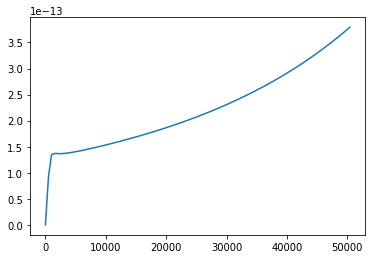

In [17]:
m = bioscrape.types.read_model_from_sbml('GFP.xml')
s = bioscrape.simulator.ModelCSimInterface(m)
import numpy as np
import matplotlib.pyplot as plt
timepoints = np.linspace(0,14*60*60,100)
s.py_prep_deterministic_simulation()
s.py_set_initial_time(timepoints[0])
sim = bioscrape.simulator.DeterministicSimulator()
result = sim.py_simulate(s, timepoints)
result = result.py_get_result()
plt.plot(timepoints,result[:,30])
plt.show()